In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 21.1 MB/s 
     |████████████████████████████████| 182 kB 52.2 MB/s 
     |████████████████████████████████| 7.6 MB 51.4 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, BertConfig,AdamW, BertForSequenceClassification,get_linear_schedule_with_warmup

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score,matthews_corrcoef

from tqdm import tqdm, trange,tnrange,tqdm_notebook
import random
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import io


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

SEED = 42 #매번 할 때마다 값이 변하지 않도록 random seed값을 고정->실험을 동일하게 진행하기 위해

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if device == torch.device("cuda"):
    torch.cuda.manual_seed_all(SEED)

In [ ]:
device = torch.device("cuda")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_train=pd.read_csv('/content/drive/MyDrive/feeling/open/train.csv')
df_txtTrain = pd.read_csv('/content/drive/MyDrive/feeling/open/train.txt',sep=";")
df_test=pd.read_csv('/content/drive/MyDrive/feeling/open/test.txt',sep=";")
df_valid = pd.read_csv('/content/drive/MyDrive/feeling/open/val.txt',sep=";")
df_train=df_train[["Utterance","Target"]]
result_train = pd.concat([df_txtTrain,df_train,df_test,df_valid])
result_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29989 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Utterance  29989 non-null  object
 1   Target     29989 non-null  object
dtypes: object(2)
memory usage: 702.9+ KB


In [5]:
mask = result_train['Target'].isin(['disgust'])

result_train = result_train[~mask]

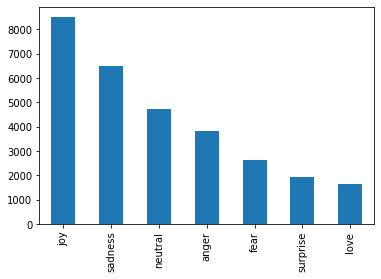

In [6]:
result_train['Target'].value_counts().plot(kind='bar')

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
result_train['Target_num'] = le.fit_transform(result_train['Target'])

In [8]:
result_train[['Target','Target_num']].drop_duplicates(keep='first')

,Target,Target_num
0,sadness,5
2,anger,0
3,love,3
6,surprise,6
7,fear,1
8,joy,2
0,neutral,4


In [9]:
result_train=result_train.drop('Target', axis=1)

In [10]:
result_train['Utterance'] = result_train['Utterance'].str.lower()
result_train=result_train.reset_index(drop=True)
result_train

,Utterance,Target_num
0,i didnt feel humiliated,5
1,i can go from feeling so hopeless to so damned...,5
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,3
4,i am feeling grouchy,0
...,...,...
29713,im having ssa examination tomorrow in the morn...,5
29714,i constantly worry about their fight against n...,2
29715,i feel its important to share this info for th...,2
29716,i truly feel that if you are passionate enough...,2


In [11]:
train_inputs,validation_inputs,train_labels,validation_labels = train_test_split(result_train['Utterance'],result_train['Target_num'],stratify=result_train['Target_num'],random_state=41,test_size=0.2)

In [12]:
test_inputs,validation_inputs,test_labels,validation_labels = train_test_split(validation_inputs,validation_labels,stratify=validation_labels,random_state=41,test_size=0.5)

In [13]:
train_data=pd.concat([train_inputs,train_labels],axis=1)
train_data=train_data.reset_index(drop=True)
train_data.head(3)

,Utterance,Target_num
0,i write and share my feelings family events us...,2
1,uh-huh. now you can turn around or you can go ...,4
2,i still find myself visiting there on my blah ...,5


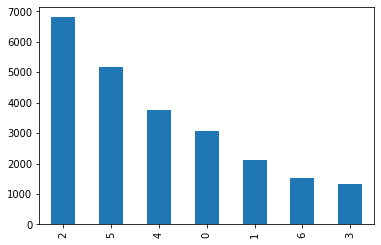

In [14]:
train_data['Target_num'].value_counts().plot(kind='bar')

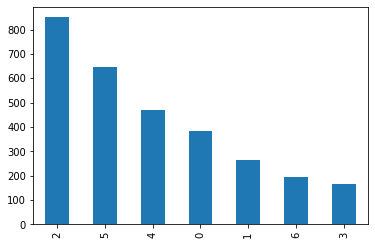

In [15]:
test_data=pd.concat([test_inputs,test_labels],axis=1)
test_data=test_data.reset_index(drop=True)
test_data['Target_num'].value_counts().plot(kind='bar')

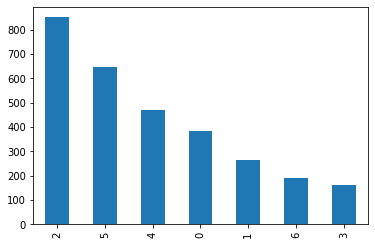

In [16]:
val_data=pd.concat([validation_inputs,validation_labels],axis=1)
val_data=val_data.reset_index(drop=True)
val_data['Target_num'].value_counts().plot(kind='bar')

In [17]:
train_sentences = train_data.Utterance.values
train_labels= train_data.Target_num.values

test_sentences = test_data.Utterance.values
test_labels= test_data.Target_num.values

val_sentences = val_data.Utterance.values
val_labels= val_data.Target_num.values

MAX_LEN = 256

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
train_input_ids = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in train_sentences]
train_labels = train_data.Target_num.values

test_input_ids = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in test_sentences]
test_labels = test_data.Target_num.values

val_input_ids = [tokenizer.encode(sent, add_special_tokens=True,max_length=MAX_LEN,pad_to_max_length=True) for sent in val_sentences]
val_labels = val_data.Target_num.values

print("Actual sentence before tokenization: ",test_sentences[2])
print("Encoded Input from dataset: ",test_labels[2])

train_masks = []
test_masks=[]
val_masks=[]

train_masks = [[float(i>0) for i in seq] for seq in train_input_ids]
test_masks = [[float(i>0) for i in seq] for seq in test_input_ids]
val_masks = [[float(i>0) for i in seq] for seq in val_input_ids]
print(train_masks[2])

Distribution of data based on labels:  2    6803
5    5184
4    3768
0    3054
1    2113
6    1539
3    1313
Name: Target_num, dtype: int64


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Actual sentence before tokenization:  i have a feeling that the robin that builds her next under our deck is getting pissed too
Encoded Input from dataset:  0
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [ ]:
train_inputs = torch.tensor(train_input_ids)
validation_inputs = torch.tensor(val_input_ids)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(val_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(val_masks)


batch_size = 16

train_data = TensorDataset(train_inputs,train_masks,train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data,sampler=train_sampler,batch_size=batch_size)

validation_data = TensorDataset(validation_inputs,validation_masks,validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data,sampler=validation_sampler,batch_size=batch_size)

In [ ]:
train_data[0]

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=8).to(device) #bert모델 불러옴 uncased는 전부다 소문자

lr = 1e-5
adam_epsilon = 1e-8

epochs = 3

num_warmup_steps = 0
num_training_steps = len(train_dataloader)*epochs

optimizer = AdamW(model.parameters(), lr=lr,eps=adam_epsilon,correct_bias=False)  
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_training_steps)  # PyTorch scheduler

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
train_loss_set = []
learning_rate = []

model.zero_grad()

for _ in tnrange(1,epochs+1,desc='Epoch'):
  print("<" + "="*22 + F" Epoch {_} "+ "="*22 + ">")

  batch_loss = 0

  for step, batch in enumerate(train_dataloader):

    model.train()
    
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    optimizer.step()
    
    scheduler.step()

    optimizer.zero_grad()
    
    batch_loss += loss.item()

  avg_train_loss = batch_loss / len(train_dataloader)

  for param_group in optimizer.param_groups:
    print("\n\tCurrent Learning rate: ",param_group['lr'])
    learning_rate.append(param_group['lr'])
    
  train_loss_set.append(avg_train_loss)
  print(F'\n\tAverage Training loss: {avg_train_loss}')
    
  # Validation

  model.eval()

  eval_accuracy,eval_mcc_accuracy,nb_eval_steps = 0, 0, 0

  for batch in validation_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch
    with torch.no_grad():
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    logits = logits[0].to('cpu').numpy()
    label_ids = b_labels.to('cpu').numpy()

    pred_flat = np.argmax(logits, axis=1).flatten()
    labels_flat = label_ids.flatten()
    
    df_metrics=pd.DataFrame({'Epoch':epochs,'Actual_class':labels_flat,'Predicted_class':pred_flat})
    
    tmp_eval_accuracy = accuracy_score(labels_flat,pred_flat)
    tmp_eval_mcc_accuracy = matthews_corrcoef(labels_flat, pred_flat)
    
    eval_accuracy += tmp_eval_accuracy
    eval_mcc_accuracy += tmp_eval_mcc_accuracy
    nb_eval_steps += 1

  print(F'\n\tValidation Accuracy: {eval_accuracy/nb_eval_steps}')
  print(F'\n\tValidation MCC Accuracy: {eval_mcc_accuracy/nb_eval_steps}')

<ipython-input-120-092e2ef2c53d>:8: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for _ in tnrange(1,epochs+1,desc='Epoch'):


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

<====================== Epoch 1 ======================>

	Current Learning rate:  6.666666666666667e-06

	Average Training loss: 0.6316713446182165

	Validation Accuracy: 0.8411738351254481

	Validation MCC Accuracy: 0.8057543944768474
<====================== Epoch 2 ======================>

	Current Learning rate:  3.3333333333333333e-06

	Average Training loss: 0.38014209937068605

	Validation Accuracy: 0.8511424731182796

	Validation MCC Accuracy: 0.8187905138703305
<====================== Epoch 3 ======================>

	Current Learning rate:  0.0

	Average Training loss: 0.31348144862058785

	Validation Accuracy: 0.8472222222222223

	Validation MCC Accuracy: 0.8134372382679094


###클래스별로 정확도 같이 측정해보기(추가로할일)


In [ ]:
model.save_pretrained('/content/drive/MyDrive/feeling/bert_uncased_model3.pt')

In [ ]:
tokenizer.save_pretrained("/content/drive/MyDrive/feeling/bert_uncased_token")

('/content/drive/MyDrive/feeling/bert_uncased_token/tokenizer_config.json',
 '/content/drive/MyDrive/feeling/bert_uncased_token/special_tokens_map.json',
 '/content/drive/MyDrive/feeling/bert_uncased_token/vocab.txt',
 '/content/drive/MyDrive/feeling/bert_uncased_token/added_tokens.json')

In [18]:
from transformers import TextClassificationPipeline,BertTokenizerFast,BertForSequenceClassification
device = torch.device('cpu')
MODEL_SAVE_PATH="/content/drive/MyDrive/feeling/bert_uncased_model3.pt"
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)
loaded_model = BertForSequenceClassification.from_pretrained(MODEL_SAVE_PATH).to(device)

text_classifier = TextClassificationPipeline(
    tokenizer=tokenizer, 
    model=loaded_model, 
    framework='pt',
)

In [19]:
predicted_list = []

for text in test_data['Utterance']:
        # predict
        preds_list = text_classifier(text)[0]
        # print("preds_list",preds_list)
        predicted_list.append(preds_list) # label
pred_list=[]
score_list=[]
for p in predicted_list:
  pred_list.append(p["label"].split("_")[1])
  score_list.append(p["score"])

In [ ]:
print(predicted_list)

[[{'label': 'LABEL_3', 'score': 0.997326135635376}], [{'label': 'LABEL_3', 'score': 0.997500479221344}], [{'label': 'LABEL_3', 'score': 0.9944347739219666}], [{'label': 'LABEL_6', 'score': 0.9968264102935791}], [{'label': 'LABEL_0', 'score': 0.5077506303787231}], [{'label': 'LABEL_6', 'score': 0.9968512654304504}], [{'label': 'LABEL_7', 'score': 0.5284783840179443}], [{'label': 'LABEL_4', 'score': 0.9880712032318115}], [{'label': 'LABEL_3', 'score': 0.480198472738266}], [{'label': 'LABEL_5', 'score': 0.251819908618927}], [{'label': 'LABEL_3', 'score': 0.9965915679931641}], [{'label': 'LABEL_7', 'score': 0.5314796566963196}], [{'label': 'LABEL_3', 'score': 0.9966723918914795}], [{'label': 'LABEL_5', 'score': 0.9517526626586914}], [{'label': 'LABEL_5', 'score': 0.9608524441719055}], [{'label': 'LABEL_5', 'score': 0.961816668510437}], [{'label': 'LABEL_3', 'score': 0.9972533583641052}], [{'label': 'LABEL_5', 'score': 0.8492568135261536}], [{'label': 'LABEL_7', 'score': 0.8089637756347656}

In [20]:
test_data['pred'] = pred_list
test_data['score'] = score_list
test_data

,Utterance,Target_num,pred,score
0,"why don’t you look in the mirror, scrud.",0,4,0.936113
1,are there no conscious men in the city for you...,5,4,0.872708
2,i have a feeling that the robin that builds he...,0,0,0.995056
3,i feel she said quickly i am so glad,2,2,0.997166
4,"that's one way! me, i- i went for the watch.",4,4,0.730054
...,...,...,...,...
2967,after my boyfriend and i had separated,5,5,0.661458
2968,im feeling happy and well,2,2,0.997086
2969,i didnt think i was angry but now that im typi...,0,0,0.995060
2970,i was feeling playful,2,2,0.996563


In [21]:
test_data['pred'] = pd.to_numeric(test_data['pred'])
test_data["Target"]=test_data["Target_num"].replace({2:"joy", 5:"sadness", 4:"neutral", 0:"anger", 1:"fear", 6:"surprise", 3:"love"})
test_data["pred"]=test_data["pred"].replace({2:"joy", 5:"sadness", 4:"neutral", 0:"anger", 1:"fear", 6:"surprise", 3:"love"})

In [22]:
from sklearn.metrics import classification_report

print(classification_report(y_true=test_data['Target'], y_pred=test_data['pred']))

              precision    recall  f1-score   support

       anger       0.84      0.77      0.80       382
        fear       0.86      0.81      0.83       264
         joy       0.89      0.88      0.88       850
        love       0.84      0.85      0.85       164
     neutral       0.76      0.83      0.79       471
     sadness       0.93      0.92      0.92       648
    surprise       0.65      0.69      0.67       193

    accuracy                           0.85      2972
   macro avg       0.82      0.82      0.82      2972
weighted avg       0.85      0.85      0.85      2972



In [33]:
from sklearn.metrics import confusion_matrix,classification_report
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    import itertools
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [24]:
cm=confusion_matrix(test_data['Target'],test_data['pred'])
print(cm)

[[293  15  17   0  27  15  15]
 [  5 213   2   0  11   8  25]
 [ 15   4 748  26  37   8  12]
 [  0   0  24 140   0   0   0]
 [ 14   3  30   0 393  15  16]
 [ 10   5   8   0  25 596   4]
 [ 10   7  14   0  27   2 133]]


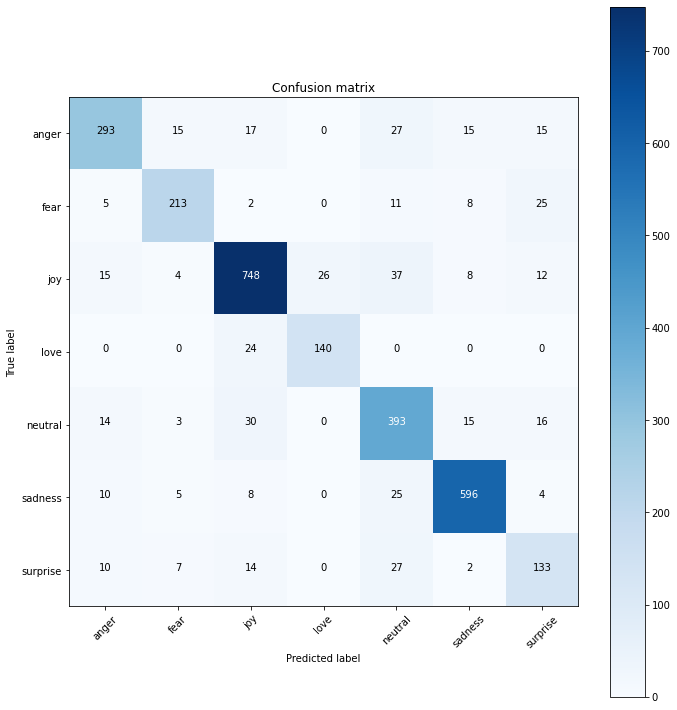

In [34]:
classes=["anger","fear","joy","love","neutral","sadness","surprise"]
plot_confusion_matrix(cm,classes)